### What impact does perceived safety have on livability in urban neighborhoods?


### 1. Import necessary modules and load pickled files

In [235]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm, tqdm_pandas
import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
with open('data/pickled/ss_orig_nyc.pkl', 'r') as picklefile:
    sso = pickle.load(picklefile)
    
with open('data/pickled/ss_withzip.pkl', 'r') as picklefile:
    ssp = pickle.load(picklefile)
    
with open('data/pickled/crime_withzip.pkl', 'r') as picklefile:
    crime = pickle.load(picklefile)

In [19]:
# split crime data into relevant years for sso and ssp data
crime2011 = crime[crime['Occurrence Year'] == 2011]
crime2014 = crime[crime['Occurrence Year'] == 2014]

### 2. Identify areas with high differences in perceived vs. actual crime by comparing actual crime rates vs. perceived crime scores

#### Perceived safety/crime scores

Normalize q-scores to 0-10 range.

In [5]:
def normalize(df, score_col, norm_col, range_start = 0, range_end = 10):
    min_score = float(df[score_col].min())
    max_score = float(df[score_col].max())
    norm_func = lambda score: range_start + (float(score) - min_score) * (range_end - range_start) / (max_score - min_score)
    normalized = [norm_func(score) for score in df[score_col].tolist()]
    df.loc[:, norm_col] = normalized

In [9]:
normalize(ssp, 'q-score', 'q_norm')
normalize(sso, 'QS Safer', 'q_norm')

Convert/invert q-score of safety to danger score.

In [10]:
normalize(ssp, 'q-score', 'q_norm_rev', range_start = 10, range_end = 0)
normalize(sso, 'QS Safer', 'q_norm_rev', range_start = 10, range_end = 0)

Get average q-score by zip code.

In [11]:
def agg_qscores(df, geo_col, score_col):
    grouped = df.groupby(geo_col)
    scores = pd.DataFrame(grouped[score_col].mean())
    return scores

In [12]:
ssbyzcta = agg_qscores(ssp, 'zcta', 'q_norm')
ss_orig_byzcta = agg_qscores(sso, 'zcta', 'q_norm')

In [13]:
ssbyz_danger = agg_qscores(ssp, 'zcta', 'q_norm_rev')
ssorigbyz_danger = agg_qscores(sso, 'zcta', 'q_norm_rev')

Get average q-score by Census tract.

In [14]:
# perceived safety
ss_by_ct = agg_qscores(ssp, 'fips_tract', 'q_norm')
ssorig_by_ct = agg_qscores(sso, 'fips_tract', 'q_norm')

In [21]:
# perceived crime
ssp_by_ct = agg_qscores(ssp, 'fips_tract', 'q_norm_rev')
sso_by_ct = agg_qscores(sso, 'fips_tract', 'q_norm_rev')

Map to shape file census tract.

In [111]:
with open('data/pickled/TRACT_DICT.pkl', 'r') as picklefile:
    tract_dict = pickle.load(picklefile)

In [113]:
# get truncated tract numbers
ssp_by_ct['tract_copy'] = ssp_by_ct.index.values
ssp_by_ct['tract_short'] = ssp_by_ct.tract_copy.apply(lambda x: tract_dict[x] if x in tract_dict else '')
ssp_by_ct.head()

,q_norm_rev,tract_short,tract_copy
fips_tract,,,
36005000200,3.726878,2000200,36005000200
36005000400,4.086433,2000400,36005000400
36005001600,3.971630,2001600,36005001600
36005001900,4.954953,2001900,36005001900
36005002000,3.646495,2002000,36005002000


Export for cartodb viz

In [706]:
def zip_to_cartodb(df, path):
    df['country'] = 'United States'
    df.to_csv(path)

In [279]:
def tract_to_cartodb(df, path):
    df['tract_copy'] = df.index.values
    df['tract_short'] = df.tract_copy.apply(lambda x: tract_dict[x] if x in tract_dict else '')
    df.drop('tract_copy', axis = 1, inplace = True)
    df.to_csv(path, index = False)

In [115]:
tract_to_cartodb(ssp_by_ct, 'data/for_cartodb/ss_by_ct.csv')

In [145]:
tract_to_cartodb(sso_by_ct, 'data/for_cartodb/ssorig_by_ct.csv')

In [707]:
zip_to_cartodb(ssbyzcta, 'data/for_cartodb/ss_by_zcta.csv')
zip_to_cartodb(ss_orig_byzcta, 'data/for_cartodb/ssorig_by_zcta.csv')

In [711]:
zip_to_cartodb(ss_by_ct, 'data/for_cartodb/ss_by_tract.csv')
zip_to_cartodb(ssorig_by_ct, 'data/for_cartodb/ssorig_by_tract.csv')

#### Actual crime scores

In [24]:
def get_crimes_by_geo(df, geo_col):
    """Given original crimes df, return df of counts by crime type by chosen geography."""
    byzip = df.groupby([geo_col, 'Offense'])
    crimesdf = byzip.OBJECTID.count().unstack(level=-1)
    crimesdf.fillna(0, inplace = True)
    crimesdf['total'] = crimesdf.sum(axis = 1)
    crimesdf[geo_col] = crimesdf.index
    return crimesdf

In [211]:
# def clean_acs(df, geo_col, data_col, geo_col_name):
#     """Given ACS zcta data file, return dictionary with key = zcta and values = data."""
#     df[geo_col_name] = df[geo_col].apply(lambda x: int(x.split()[1]) if len(x.split()) > 1 else x)
#     data_dict = dict(zip(df[geo_col_name].values, df[data_col].values.tolist()))
#     return data_dict

def add_acs_data(acs_df, acs_geo_col, acs_data_col, df, df_geo_col, df_new_data_name):
    """Given ACS zcta data file, return dictionary with key = geography and values = data."""
    # create dictionary of {geo: value} from acs data
    data_dict = dict(zip(acs_df[acs_geo_col].values, acs_df[acs_data_col].values.tolist()))
    
    # fetch value for key and add to df 
    df[df_new_data_name] = df.loc[:, df_geo_col].apply(lambda x: int(data_dict[x]) if x in data_dict else np.nan)

In [17]:
# def clean_acs_df(df, zcta_col, data_col):
#     """Given ACS zcta data file, return df of relevant data."""
#     df['zcta'] = df[zcta_col].apply(lambda x: int(x.split()[1]) if len(x.split()) > 1 else x)
#     keep = data_col + ['zcta']
#     return df[keep]

In [ ]:
"""normalizing crime:
- crime rate - crime per 100,000 residents
- great post: http://opendata.stackexchange.com/questions/381/how-to-normalize-the-data-when-mapping-crime-reports
"""

#### Normalize data by converting raw crime count to crime rates based on census tract population.

Potential ways of normalizing: 
* by population in that geography
    * problematic for areas with fewer residents
* by area of the geography
 

In [213]:
# get dataframe of crimes by geography
crime2014_ct = get_crimes_by_geo(crime2014, 'fips_tract')

Normalize by worker and resident population.

In [ ]:
# fetch population data
pop_ct = pd.read_csv('data/dem_data/acs_pop_by_ct_2014.csv')

In [214]:
add_acs_data(pop_ct, 'GEO.id2', 'HC01_VC03', crime2014_ct, 'fips_tract', 'population')

In [215]:
# fetch worker data
workers = pd.read_csv('data/dem_data/lehd_workers_2014.csv')

# add census tract to worker data
workers['tract'] = workers.w_geocode.apply(lambda x: str(x)[:12])

In [216]:
def clean_workers(df):
    df['tract'] = df.w_geocode.apply(lambda x: str(x)[:11])
    by_tract = df.groupby('tract')
    newdf = pd.DataFrame(by_tract['C000'].sum())
    newdf['tract'] = newdf.index
    newdf.rename(columns = {'C000': 'total_workers'}, inplace = True)
    return newdf

In [217]:
workers2 = clean_workers(workers)

In [218]:
# add worker data to crime df
worker_dict = dict(zip(workers2.tract, workers2.total_workers))
crime2014_ct['workers'] = crime2014_ct.fips_tract.apply(lambda x: worker_dict[x] if x in worker_dict else np.nan)

In [219]:
# add resident and worker population
crime2014_ct['total_pop'] = crime2014_ct.loc[:,'population'] + crime2014_ct.loc[:, 'workers']

In [223]:
crime2014_ct.dropna(inplace = True) # drop tracts with missing pop or worker counts

In [247]:
crime2014_ct = crime2014_ct[crime2014_ct.total_pop > 1000] # remove tracts with total pop < 1000
crime2014_ct['crime_rate_pop'] = (crime2014_ct.total / crime2014_ct.total_pop) * 1000

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(array([ 366.,  816.,  467.,  196.,   81.,   43.,   14.,    5.,    3.,    1.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.]),
 <a list of 10 Patch objects>)

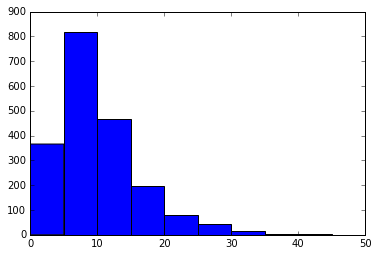

In [248]:
plt.hist(crime2014_ct.crime_rate_pop, range = [0, 50])

(array([ 800.,  847.,  243.,   79.,   17.,    4.,    3.,    2.,    0.,    3.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <a list of 10 Patch objects>)

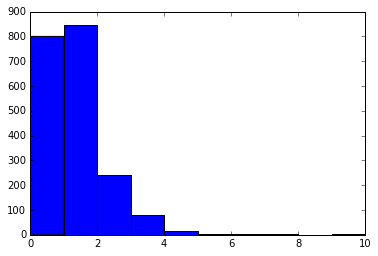

In [258]:
plt.hist(crime2014_ct.crime_rate_pop_norm)

In [256]:
# normalize crime rate to be between 0 and 10 
normalize(crime2014_ct, 'crime_rate_pop', 'crime_rate_pop_norm')

Normalize by census tract size.

In [252]:
# pull in detailed census tract data
with open('data/pickled/TRACT_DF.pkl', 'r') as picklefile:
    tract_df = pickle.load(picklefile)

In [253]:
# normalize crime by census tract size
ct_size = dict(zip(tract_df.fips.values, tract_df.Shape_Area))
crime2014_ct['tract_area'] = crime2014_ct.fips_tract.apply(lambda x: ct_size[x] if x in ct_size else 'no data')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [254]:
# divide crime count per tract by shape area -- what are the units??
crime2014_ct['crime_rate_area'] = (crime2014_ct.total / crime2014_ct.tract_area) * 100000

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [255]:
# normalize crime rate by area to 0-10 scale
normalize(crime2014_ct, 'crime_rate_area', 'crime_rate_area_norm')

In [259]:
crime2014_ct.head()

Offense,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON-NEGL. MANSLAUGHTE,RAPE,ROBBERY,total,fips_tract,population,workers,total_pop,crime_rate_pop,crime_rate_pop_norm,tract_area,crime_rate_area,crime_rate_area_norm
fips_tract,,,,,,,,,,,,,,,,,
36005000200,9,10,10,2,0,0,5,36,36005000200,5095,51,5146,6.995725,0.925745,5050182.71191,0.712845,0.267828
36005000400,6,10,12,6,0,0,4,38,36005000400,5572,310,5882,6.460388,0.853635,8551573.02668,0.444363,0.166665
36005001600,7,16,17,7,1,0,14,62,36005001600,5412,578,5990,10.350584,1.377643,5221332.29582,1.187436,0.446652
36005001900,15,16,32,19,0,0,10,92,36005001900,2569,5666,8235,11.171828,1.488265,17964480.95910,0.512122,0.192197
36005002000,15,38,23,8,0,0,33,117,36005002000,8959,132,9091,12.869871,1.716990,4270706.70640,2.739593,1.031497


#### Export crime data to cartodb for viz

In [ ]:
# raw crime counts, crime rate by population, and crime rate by tract area
crime_cartodb = crime2014_ct[['total', 'crime_rate_pop', 'crime_rate_pop_norm', 'crime_rate_area', 'crime_rate_area_norm']]
tract_to_cartodb(crime_cartodb, 'data/for_cartodb/crime_by_tract2.csv')

In [391]:
# # map population and divide crime by population
# crbyzip2014['population'] = crbyzip2014.zcta.apply(lambda x: int(pop_zcta[x][0]) if x in pop_zcta else np.nan)
# crbyzip2014['crime_p_1k'] = (crbyzip2014.total / crbyzip2014.population) * 1000

In [725]:
# # drop nans and 0s
# crbyzip2014.dropna(subset = ['crime_p_1k'], inplace = True)
# crbyzip2014 = crbyzip2014[crbyzip2014.population > 1]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [729]:
# zip_to_cartodb(crbyzip2014, 'data/for_cartodb/crime_by_zip_2014.csv')

#### Compare crime vs. perceived safety

Potential scores:
* ratio of perceived safety (or perceived crime, inverse) to actual crime rate
* quantile/rank of zip compared to other zip codes? e.g. 5th most "least safe" (dangerous) vs. 100th highest crime rate

In [84]:
ssp_by_ct.head()

,q_norm_rev
fips_tract,
36005000200,3.726878
36005000400,4.086433
36005001600,3.971630
36005001900,4.954953
36005002000,3.646495


In [261]:
crime2014_ct.head()

Offense,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON-NEGL. MANSLAUGHTE,RAPE,ROBBERY,total,fips_tract,population,workers,total_pop,crime_rate_pop,crime_rate_pop_norm,tract_area,crime_rate_area,crime_rate_area_norm
fips_tract,,,,,,,,,,,,,,,,,
36005000200,9,10,10,2,0,0,5,36,36005000200,5095,51,5146,6.995725,0.925745,5050182.71191,0.712845,0.267828
36005000400,6,10,12,6,0,0,4,38,36005000400,5572,310,5882,6.460388,0.853635,8551573.02668,0.444363,0.166665
36005001600,7,16,17,7,1,0,14,62,36005001600,5412,578,5990,10.350584,1.377643,5221332.29582,1.187436,0.446652
36005001900,15,16,32,19,0,0,10,92,36005001900,2569,5666,8235,11.171828,1.488265,17964480.95910,0.512122,0.192197
36005002000,15,38,23,8,0,0,33,117,36005002000,8959,132,9091,12.869871,1.716990,4270706.70640,2.739593,1.031497


In [270]:
def compare_crime(ssdf, crimedf):
    """Aggregate streetscore (perceived) and actual crime data for comparison."""
    # merge dataframes and clean up columns
    merged = ssdf.merge(crimedf, left_index = True, right_index = True)
    keep = ['fips_tract', 'q_norm_rev', 'total', 'crime_rate_pop', 'crime_rate_pop_norm', \
            'crime_rate_area', 'crime_rate_area_norm']
    newdf = merged[keep]
    newdf.rename(columns = {'q_norm_rev': 'perceived_danger', 'total': 'raw_crime_count'} , inplace = True)
    
    # add comparison scores
    # straight difference
    newdf['per_act_diff'] = newdf.loc[:, 'perceived_danger'] - newdf.loc[:, 'crime_rate_pop_norm'] 
    
    # ratio between perceived and actual rate 
    newdf['per_act_ratio'] = newdf.loc[:, 'perceived_danger'] / newdf.loc[:, 'crime_rate_pop_norm']
    
    return newdf

In [271]:
ratios = compare_crime(ssp_by_ct, crime2014_ct)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [278]:
ratios.head(3)

,fips_tract,perceived_danger,raw_crime_count,crime_rate_pop,crime_rate_pop_norm,crime_rate_area,crime_rate_area_norm,per_act_diff,per_act_ratio
fips_tract,,,,,,,,,
36005000200,36005000200,3.726878,36,6.995725,0.925745,0.712845,0.267828,2.801133,4.025816
36005000400,36005000400,4.086433,38,6.460388,0.853635,0.444363,0.166665,3.232798,4.787095
36005001600,36005001600,3.971630,62,10.350584,1.377643,1.187436,0.446652,2.593986,2.882916


In [280]:
tract_to_cartodb(ratios, 'data/for_cartodb/crime_by_tract3.csv')

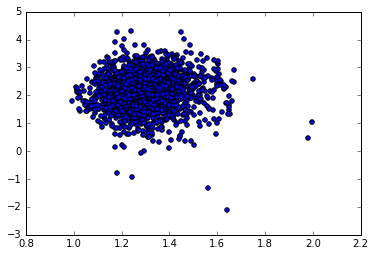

In [286]:
import numpy as np
plt.scatter(np.log(ratios.perceived_danger), np.log(ratios.crime_rate_pop))

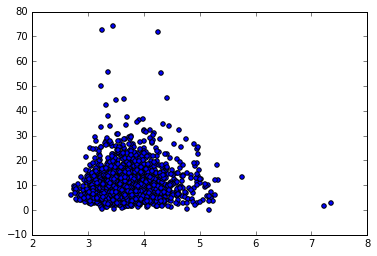

In [287]:
plt.scatter(ratios.perceived_danger, ratios.crime_rate_pop)

In [288]:
ratios[ratios['perceived_danger'] > 7]

,fips_tract,perceived_danger,raw_crime_count,crime_rate_pop,crime_rate_pop_norm,crime_rate_area,crime_rate_area_norm,per_act_diff,per_act_ratio,tract_short
fips_tract,,,,,,,,,,
36061008601,36061008601,7.230782,5,1.603078,0.199357,0.409371,0.153481,7.031425,36.270488,1008601
36061031900,36061031900,7.359993,3,2.824859,0.363931,0.277744,0.103885,6.996063,20.223616,1031900


In [289]:
crime[crime.fips_tract == '36061008601']

,OBJECTID,Identifier,Occurrence Date,Day of Week,Occurrence Month,Occurrence Day,Occurrence Year,Occurrence Hour,CompStat Month,CompStat Day,...,XCoordinate,YCoordinate,Location 1,lat,lon,zipcode,zcta,fips_detail,fips_bg,fips_tract
8144,8145,a8780d4,01/20/2006 04:00:00 PM,Friday,Jan,20,2006,16,3,22,...,991768,210161,"(40.743525027, -73.972870423)",40.743525027,-73.972870423,10016,10016,"{u'AWATER10': 0, u'TRACTCE10': u'008601', u'AL...",360610086012,36061008601
16486,16487,5282fd7e,05/14/2006 08:00:00 AM,Sunday,May,14,2006,8,12,7,...,991768,210161,"(40.743525027, -73.972870423)",40.743525027,-73.972870423,10016,10016,"{u'AWATER10': 0, u'TRACTCE10': u'008601', u'AL...",360610086012,36061008601
32849,32850,dfb38c81,03/01/2006 12:00:00 PM,Wednesday,Mar,1,2006,12,3,13,...,992140,210859,"(40.745440538, -73.9715271279999)",40.745440538,-73.9715271279999,10016,10016,"{u'AWATER10': 0, u'TRACTCE10': u'008601', u'AL...",360610086011,36061008601
38271,38272,6cd2b8d3,02/03/2006 12:30:00 AM,Friday,Feb,3,2006,0,2,4,...,991768,210161,"(40.743525027, -73.972870423)",40.743525027,-73.972870423,10016,10016,"{u'AWATER10': 0, u'TRACTCE10': u'008601', u'AL...",360610086012,36061008601
39890,39891,1ed85df3,01/28/2006 06:35:00 PM,Saturday,Jan,28,2006,18,1,28,...,992093,210298,"(40.743900776, -73.971697401)",40.743900776,-73.971697401,10016,10016,"{u'AWATER10': 0, u'TRACTCE10': u'008601', u'AL...",360610086012,36061008601
42517,42518,bec9dea3,02/10/2006 08:30:00 PM,Friday,Feb,10,2006,20,2,11,...,991910,210400,"(40.7441809000001, -73.9723577)",40.7441809000001,-73.9723577,10016,10016,"{u'AWATER10': 0, u'TRACTCE10': u'008601', u'AL...",360610086012,36061008601
79272,79273,59fe37a1,06/27/2006 08:15:00 PM,Tuesday,Jun,27,2006,20,6,27,...,991768,210161,"(40.743525027, -73.972870423)",40.743525027,-73.972870423,10016,10016,"{u'AWATER10': 0, u'TRACTCE10': u'008601', u'AL...",360610086012,36061008601
83963,83964,d31a2d36,01/25/2007 08:30:00 PM,Thursday,Jan,25,2007,20,1,25,...,991768,210161,"(40.743525027, -73.972870423)",40.743525027,-73.972870423,10016,10016,"{u'AWATER10': 0, u'TRACTCE10': u'008601', u'AL...",360610086012,36061008601
117911,117912,25f53ee7,08/30/2006 08:58:00 AM,Wednesday,Aug,30,2006,8,8,30,...,991910,210400,"(40.7441809000001, -73.9723577)",40.7441809000001,-73.9723577,10016,10016,"{u'AWATER10': 0, u'TRACTCE10': u'008601', u'AL...",360610086012,36061008601
154234,154235,271a0b8a,12/20/2006 06:30:00 PM,Wednesday,Dec,20,2006,18,12,20,...,992183,210542,"(40.7445704140001, -73.971372319)",40.7445704140001,-73.971372319,10016,10016,"{u'AWATER10': 0, u'TRACTCE10': u'008601', u'AL...",360610086011,36061008601


next steps
- build regression model to try and predict perceived safety score by image 
- see if actual crime rates can predict perceived safety score -- answer the question of whether or not people perceive crime based on actual crime
- see if other features can predict perceived crime, such as zoning, construction permits, etc. 